In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#country = "US"
country = 'India'

#Total COVID confirmed cases
df_confirmed = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
#df_confirmed.to_csv('global.csv')

In [2]:
df_confirmed.head(10)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/24/21,2/25/21,2/26/21,2/27/21,2/28/21,3/1/21,3/2/21,3/3/21,3/4/21,3/5/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,55664,55680,55696,55707,55714,55733,55759,55770,55775,55827
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,103327,104313,105229,106215,107167,107931,108823,109674,110521,111301
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,112461,112622,112805,112960,113092,113255,113430,113593,113761,113948
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,10775,10799,10822,10849,10866,10889,10908,10948,10976,10998
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,20640,20695,20759,20782,20807,20854,20882,20923,20981,21026
5,NaN,Antigua and Barbuda,17.06080,-61.796400,0,0,0,0,0,0,...,646,701,701,726,730,769,769,769,813,813
6,NaN,Argentina,-38.41610,-63.616700,0,0,0,0,0,0,...,2085411,2093645,2098728,2104197,2107365,2112023,2118676,2126531,2133963,2141854
7,NaN,Armenia,40.06910,45.038200,0,0,0,0,0,0,...,170945,171227,171510,171793,172058,172216,172456,172816,173307,173749
8,Australian Capital Territory,Australia,-35.47350,149.012400,0,0,0,0,0,0,...,118,118,118,118,118,118,120,120,120,120
9,New South Wales,Australia,-33.86880,151.209300,0,0,0,0,3,4,...,5162,5166,5172,5177,5180,5183,5189,5193,5205,5207


Total days in the dataset 409


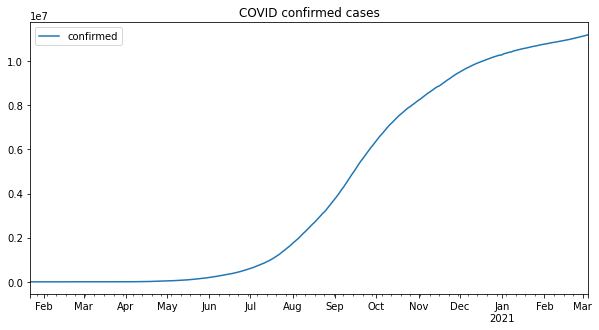

In [3]:
df_confirmed_country = df_confirmed[df_confirmed["Country/Region"] == country]
df_confirmed_country = pd.DataFrame(df_confirmed_country[df_confirmed_country.columns[4:]].sum(),columns=["confirmed"])
df_confirmed_country.index = pd.to_datetime(df_confirmed_country.index,format='%m/%d/%y')

df_confirmed_country.plot(figsize=(10,5),title="COVID confirmed cases")

print("Total days in the dataset", len(df_confirmed_country))


In [4]:
df_confirmed_country.head(10)

,confirmed
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0
2020-01-27,0
2020-01-28,0
2020-01-29,0
2020-01-30,1
2020-01-31,1


In [5]:
df_confirmed_country.tail(10)

,confirmed
2021-02-24,11046914
2021-02-25,11063491
2021-02-26,11079979
2021-02-27,11096731
2021-02-28,11112241
2021-03-01,11124527
2021-03-02,11139516
2021-03-03,11156923
2021-03-04,11173761
2021-03-05,11192045


In [6]:
df_confirmed_country.tail(10)

,confirmed
2021-02-24,11046914
2021-02-25,11063491
2021-02-26,11079979
2021-02-27,11096731
2021-02-28,11112241
2021-03-01,11124527
2021-03-02,11139516
2021-03-03,11156923
2021-03-04,11173761
2021-03-05,11192045


In [7]:
print("Total days in the dataset", len(df_confirmed_country))

#Use data until 14 days before as training
x = len(df_confirmed_country)-14

Total days in the dataset 409


In [8]:

train=df_confirmed_country.iloc[:x]
test = df_confirmed_country.iloc[x:]


In [9]:
##scale or normalize data as the data is too skewed
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train) 

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

In [10]:
from keras.preprocessing.sequence import TimeseriesGenerator
seq_size = 7  ## number of steps (lookback)
n_features = 1 ## number of features. This dataset is univariate so it is 1
train_generator = TimeseriesGenerator(train_scaled, train_scaled, length = seq_size, batch_size=1)
print("Total number of samples in the original training data = ", len(train)) # 271
print("Total number of samples in the generated data = ", len(train_generator)) # 264 with seq_size=7

Total number of samples in the original training data =  395
Total number of samples in the generated data =  388


In [11]:
x,y = train_generator[10] 

In [12]:
x.shape

(1, 7, 1)

In [13]:
test_generator = TimeseriesGenerator(test_scaled, test_scaled, length=seq_size, batch_size=1)
print("Total number of samples in the original training data = ", len(test)) # 14 as we're using last 14 days for test
print("Total number of samples in the generated data = ", len(test_generator)) # 7

Total number of samples in the original training data =  14
Total number of samples in the generated data =  7


In [14]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation

#Define Model 
model = Sequential()
model.add(LSTM(256, activation='relu', return_sequences=True, input_shape=(seq_size, n_features)))
model.add(LSTM(64, activation='relu'))
model.add(Dense(64))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()
print('Train...')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 256)            264192    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                82176     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 350,593
Trainable params: 350,593
Non-trainable params: 0
_________________________________________________________________
Train...


In [15]:

history = model.fit_generator(train_generator, 
                              validation_data=test_generator, 
                              epochs=50, steps_per_epoch=10)

Epoch 1/50


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


10/10 [==============================] - 3s 86ms/step - loss: 0.2198 - val_loss: 0.4008
Epoch 2/50
10/10 [==============================] - 0s 17ms/step - loss: 0.0733 - val_loss: 0.0805
Epoch 3/50
10/10 [==============================] - 0s 16ms/step - loss: 0.0490 - val_loss: 0.1247
Epoch 4/50
10/10 [==============================] - 0s 17ms/step - loss: 0.0383 - val_loss: 0.0168
Epoch 5/50
10/10 [==============================] - 0s 16ms/step - loss: 0.0065 - val_loss: 0.0239
Epoch 6/50
10/10 [==============================] - 0s 16ms/step - loss: 0.0071 - val_loss: 1.5394e-05
Epoch 7/50
10/10 [==============================] - 0s 16ms/step - loss: 5.3318e-04 - val_loss: 5.2382e-04
Epoch 8/50
10/10 [==============================] - 0s 16ms/step - loss: 1.9648e-04 - val_loss: 1.1714e-04
Epoch 9/50
10/10 [==============================] - 0s 16ms/step - loss: 2.4070e-05 - val_loss: 9.7881e-06
Epoch 10/50
10/10 [==============================] - 0s 16ms/step - loss: 6.0585e-05 - val_l

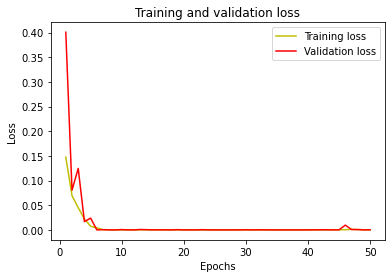

In [16]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
prediction = [] #Empty list to populate later with predictions

current_batch = train_scaled[-seq_size:] #Final data points in train 
current_batch = current_batch.reshape(1, seq_size, n_features) #Reshape



In [18]:
current_batch[0]

array([[0.99340034],
       [0.99446152],
       [0.99529241],
       [0.99635004],
       [0.99752345],
       [0.99872529],
       [1.        ]])

In [19]:
## Predict future, beyond test dates
future = 7 #Days
for i in range(len(test) + future):
    current_pred = model.predict(current_batch)[0]
    prediction.append(current_pred)
    print(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    print(current_batch)

[0.98701394]
[[[0.99446152]
  [0.99529241]
  [0.99635004]
  [0.99752345]
  [0.99872529]
  [1.        ]
  [0.98701394]]]
[0.9871502]
[[[0.99529241]
  [0.99635004]
  [0.99752345]
  [0.99872529]
  [1.        ]
  [0.98701394]
  [0.98715019]]]
[0.9865799]
[[[0.99635004]
  [0.99752345]
  [0.99872529]
  [1.        ]
  [0.98701394]
  [0.98715019]
  [0.9865799 ]]]
[0.98560905]
[[[0.99752345]
  [0.99872529]
  [1.        ]
  [0.98701394]
  [0.98715019]
  [0.9865799 ]
  [0.98560905]]]
[0.98424476]
[[[0.99872529]
  [1.        ]
  [0.98701394]
  [0.98715019]
  [0.9865799 ]
  [0.98560905]
  [0.98424476]]]
[0.9823117]
[[[1.        ]
  [0.98701394]
  [0.98715019]
  [0.9865799 ]
  [0.98560905]
  [0.98424476]
  [0.98231173]]]
[0.9798747]
[[[0.98701394]
  [0.98715019]
  [0.9865799 ]
  [0.98560905]
  [0.98424476]
  [0.98231173]
  [0.97987467]]]
[0.9768859]
[[[0.98715019]
  [0.9865799 ]
  [0.98560905]
  [0.98424476]
  [0.98231173]
  [0.97987467]
  [0.97688591]]]
[0.9757466]
[[[0.9865799 ]
  [0.98560905]
  [

In [20]:


### Inverse transform to before scaling so we get actual numbers
rescaled_prediction = scaler.inverse_transform(prediction)

time_series_array = test.index  #Get dates for test data

#Add new dates for the forecast period
for k in range(0, future):
    time_series_array = time_series_array.append(time_series_array[-1:] + pd.DateOffset(1))

#Create a dataframe to capture the forecast data
df_forecast = pd.DataFrame(columns=["actual_confirmed","predicted"], index=time_series_array)

df_forecast.loc[:,"predicted"] = rescaled_prediction[:,0]
df_forecast.loc[:,"actual_confirmed"] = test["confirmed"]

<AxesSubplot:title={'center':'Predictions for next 7 days'}>

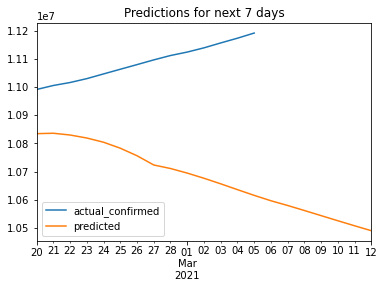

In [21]:
#Plot
df_forecast.plot(title="Predictions for next 7 days")

In [22]:

time_series_array = test.index  #Get dates for test data

time_series_array

DatetimeIndex(['2021-02-20', '2021-02-21', '2021-02-22', '2021-02-23',
               '2021-02-24', '2021-02-25', '2021-02-26', '2021-02-27',
               '2021-02-28', '2021-03-01', '2021-03-02', '2021-03-03',
               '2021-03-04', '2021-03-05'],
              dtype='datetime64[ns]', freq=None)